# Disease Detection in Plants
This is a project which aims to compare the accuracy of different classic ML classification algorithms in plant disease detection.
This notebook will take you through the process of processing the images and building a model to detect plant disease using the dataset from [PlantVillage](https://github.com/spMohanty/PlantVillage-Dataset/tree/master/raw/color).

## Dataset
Before we can start building and assessing different models, we need to take a closer look at our dataset.
Our dataset contains 1600 photos of plant leaves, 800 are labelled healthy and 800 are labelled diseased.

Type of File : JPG File.
Dimensions : 256px * 256px.
Horizontal and Vertical Resolution : 96 dpi.

## Pre-processing
We can look at an example of a healthy leaf and a diseased leaf below:

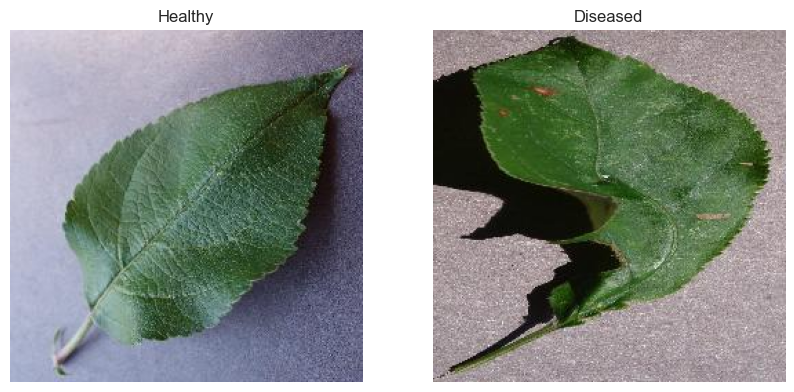

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10)) #Set the size of the figure

# First subplot for the healthy image
healthy = cv2.imread('./healthy.jpg')
healthy_rgb = cv2.cvtColor(healthy, cv2.COLOR_BGR2RGB) #change image from BGR to RGB (CV2 uses BGR by default)

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(healthy_rgb)
plt.title('Healthy') #Healthy label
plt.axis('off')  # Hide the axis


# Second subplot for the diseased image
diseased = cv2.imread('./diseased.jpg')
diseased_rgb = cv2.cvtColor(diseased, cv2.COLOR_BGR2RGB) #change image from BGR to RGB

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(diseased_rgb)
plt.title('Diseased') #Diseased label
plt.axis('off')  # Hide the axis

plt.show()

You can see that the lighting is not consistent between all the images. It would be best to process the images accordingly to remove the background and shadows, so we can eliminate unnecessary bias that could be caused by any irrelevant elements.

Let's take this image of a diseased leaf and try to segment it accordingly:

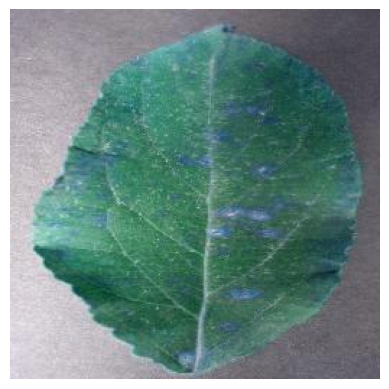

In [74]:
image = cv2.imread('./example.jpg')
plt.imshow(image)
plt.axis('off') 
plt.show()

Since the CV2 library uses the BGR color profile by default (causing the bluish tint), we can convert the image to RGB, so it is easier on the eyes.
With every step we take here, we're going to make functions, so we can modularize our code better and increase the readability down the line.

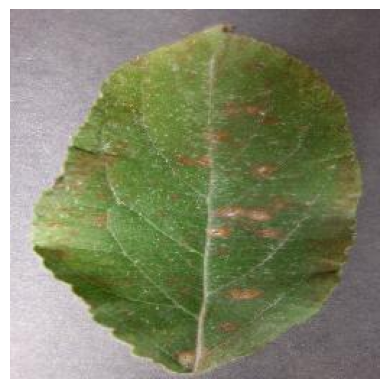

In [75]:
def bgr_rgb(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Converting color from BGR to RGB
    return rgb_img

rgb_image = bgr_rgb(image) #Calling the function

plt.imshow(rgb_image) #Showing the image
plt.axis('off')
plt.show()

To be able to segment the image properly, it would be good if we could also turn the image into the HSV color profile which could make the difference between the background and foreground more obvious.

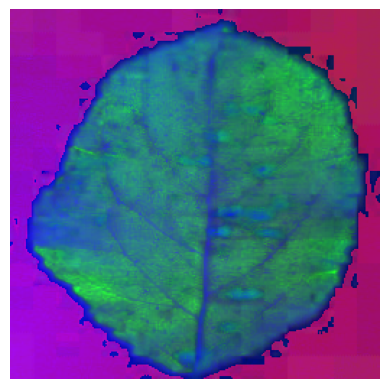

In [76]:
def rgb_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) #Converting from RGB to HSV
    return hsv_image

hsv_image = rgb_hsv(rgb_image) #Calling the function

plt.imshow(hsv_image) #Showing the image
plt.axis('off')
plt.show()

The difference is now much more obvious between the foreground and background. We can use the difference in colors to only take into account the color values that are obviously part of the leaf itself, and after discarding te unwanted colors, we can overlay a mask of the wanted pixels on top of the RGB image to see if we were successful.
We can use this to start segmenting the image to remove the background:

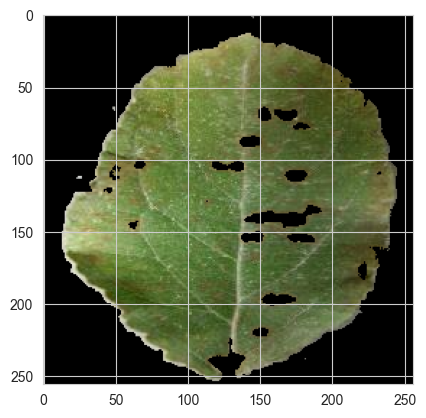

In [77]:
def leaf_segment(hsv_image):   
    lower_green = np.array([25,0,20]) #Array with lower bound of acceptable green color values
    upper_green = np.array([100,255,255]) #Array with upper bound of acceptable green color values
    leaf_mask = cv2.inRange(hsv_image, lower_green, upper_green) #Removing unwanted colors on the HSV image
    return leaf_mask

#Putting the remaining pixels back on the RGB image using bitwise and
leaf_result = cv2.bitwise_and(rgb_image, rgb_image, mask=leaf_segment(hsv_image)) 

plt.imshow(leaf_result)
plt.show()

It seems like there are a few missing brown spots from the leaf. This isn't good as the spots on the leaf may be the diseased spots that we want our model to look out for.
If we increase the range of acceptable colors for our mask, it might risk taking in parts of the background into the final product, so instead we can try to isolate the spots that were left out and combine them after.

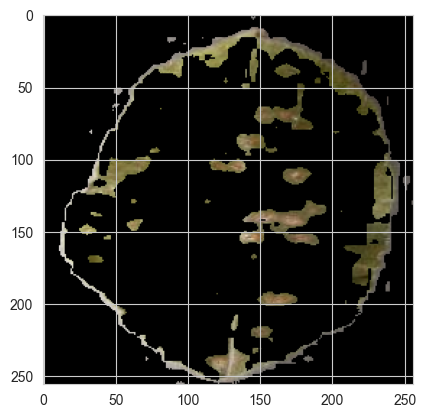

In [78]:
def spot_segment(hsv_image):
    lower_brown = np.array([10,0,10]) #Array with lower bound of acceptable brown color values
    upper_brown = np.array([30,255,255]) #Array with upper bound of acceptable brown color values
    spot_mask = cv2.inRange(hsv_image, lower_brown, upper_brown) #Removing unwanted colors on the HSV image
    return spot_mask
#Putting the remaining pixels back on the RGB image using a bitwise and
spots_result = cv2.bitwise_and(rgb_image, rgb_image, mask=spot_segment(hsv_image)) 

plt.imshow(spots_result)
plt.show()

That worked! Now let's combine the two masks:

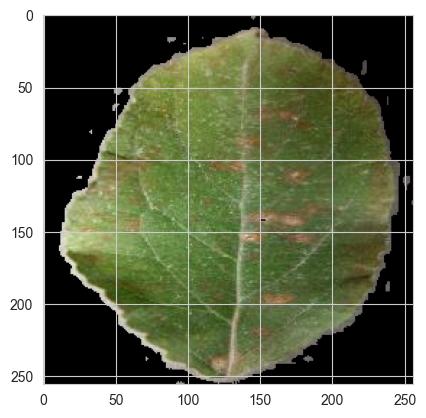

In [79]:
def final_segment(rgb_image, hsv_image):
    leaf = leaf_segment(hsv_image) #Calling the leaf segment function to get the leaf mask
    spots = spot_segment(hsv_image) #Calling the spot segment function to get the spot mask
    final_mask = leaf + spots #combining masks together
    final_result = cv2.bitwise_and(rgb_image, rgb_image, mask=final_mask) #laying the mask over the image
    return final_result

final_image = final_segment(rgb_image,hsv_image)
plt.imshow(final_image)
plt.show()

The final image that we produced is much better now. You might notice that there are a few extra or missing spots on the image, you can try and get the best segmentation you can by playing around with the acceptable color values of the leaf and spots.

## Building the model
Now that we finalized the pre-processing, we can start building our model.
We need to start by importing the libraries we need and setting our tunable parameters.

In [80]:
#Initial imports for preprocessing
from sklearn.preprocessing import LabelEncoder
import numpy as np
import mahotas
import cv2
import os
import h5py

#Tunable-parameters
images_per_class       = 800 #How many images per healthy/diseased classes
fixed_size             = tuple((500, 500)) #resizing all images
train_path             = "dataset/train"
h5_train_data          = 'output/train_data.h5'
h5_train_labels        = 'output/train_labels.h5'
bins                   = 8 #Used for color histogram calculations

### Setting up
To set up our model, we need to define the features that we are going to extract, and the labels that we are going to attach to our data.
The features that we are going to use for our data are:
1. **Hu Moments**: Set of seven numbers derived from image pixels, invariant to image scale, rotation, and translation. Used for shape recognition in images.

2. **Haralick Texture Features**: Based on the Gray-Level Co-occurrence Matrix (GLCM), these 14 features describe the texture of an image, useful in analyzing patterns and surface variations.

3. **Color Histogram**: Graphical representation of color distribution in an image, showing the frequency of each color. Useful for image comparison, recognition, and segmentation.

The labels are 'diseased' and 'healthy' which we can get from the file names.

In [81]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #image to greyscale
    hu_moments = cv2.HuMoments(cv2.moments(image)).flatten() 
    #we flatten because HuMoments gives us an array of shape (1,7) or (7,1)
    return hu_moments

In [82]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #image to greyscale
    haralick = mahotas.features.haralick(gray).mean(axis=0) #haralick texture is not available in cv2, so we use mahotas
    return haralick

In [83]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing to from bgr to HSV
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256]) 
    #Calculates the 3D histogram for our image
    cv2.normalize(hist, hist) 
    #Normalizing our histogram so the values add up to one, which stops the image from beign affected by brightness
    return hist.flatten()

In [84]:
#Get the training labels from the files
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

#Empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


### Extraction and Organization
We can now start by labelling our data and extracting the features from our images.

In [85]:
#Looping over the training data sub-folders
for training_name in train_labels:
    #Join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)
    
    #Get the current training label
    current_label = training_name

    #Loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        #Get the image file name
        file = dir + "/" + str(x) + ".jpg"
        #Read the image and resize it to the fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        #Segmenting the image
        rgb_image = bgr_rgb(image)
        hsv_image = rgb_hsv(rgb_image)
        final_image = final_segment(rgb_image,hsv_image)

        #Extract features from the final image
        fv_hu_moments = fd_hu_moments(final_image)
        fv_haralick = fd_haralick(final_image)
        fv_histogram = fd_histogram(final_image)
        
        #Concatenate all the features into a global feature to represent the comprehensive characteristics of the image
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    
        #Update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[DONE] processed folder: {}".format(current_label))
print("[DONE] completed Global Feature Extraction...")

[DONE] processed folder: diseased
[DONE] processed folder: healthy
[DONE] completed Global Feature Extraction...


After we are done, we can print out the vectors that we have produced and their details

In [86]:
#print(global_features)

In [87]:
#Overall feature vector size
print("[DONE] feature vector size {}".format(np.array(global_features).shape))

[DONE] feature vector size (1600, 532)


In [88]:
#Overall training label size
print("[DONE] training Labels {}".format(np.array(labels).shape))

[DONE] training Labels (1600,)


We encode our labels and scale our features to prepare them for training

In [89]:
#Encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target= le.fit_transform(labels)
print("[DONE] training labels encoded...")

[DONE] training labels encoded...


In [90]:
#Scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[DONE] feature vector normalized...")

[DONE] feature vector normalized...


In [91]:
print("[DONE] target labels: {}".format(target))
print("[DONE] target labels shape: {}".format(target.shape))

[DONE] target labels: [0 0 0 ... 1 1 1]
[DONE] target labels shape: (1600,)


Using h5py allows us to save the features and labels that we have extracted, we can then use this set for training and testing without having to worry about multiple files in the dataset.

In [92]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1600, 532), type "<f8">

In [93]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (1600,), type "<i8">

In [94]:
h5f_data.close()
h5f_label.close()

## Training the model
Now for the fun part, we import the all the ML algorithms that we want to use, if you want to use another classification algorithm all you have to do is import it and append it to the models list.
We are using an 80/20 train-test split, and 10-fold cross validation. Check out the tunable parameters to play with these.


In [95]:
import os
import h5py
import numpy as np
import cv2
import warnings
from matplotlib import pyplot

#Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Suppress warnings
warnings.filterwarnings('ignore')

#Tunable parameters
num_trees = 100
test_size = 0.20
seed = 9
folds = 10
train_path = "dataset/train"
test_path = "dataset/test"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'
scoring = "accuracy"

#Function to create and return machine learning models, you can add new models here
def create_models(seed):
    models = [
        ('LR', LogisticRegression(random_state=seed)),
        ('LDA', LinearDiscriminantAnalysis()),
        ('KNN', KNeighborsClassifier()),
        ('DTC', DecisionTreeClassifier(random_state=seed)),
        ('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)),
        ('NB', GaussianNB()),
        ('SVC', SVC(random_state=seed))
    ]
    return models

#Ensure the test path exists
if not os.path.exists(test_path):
    os.makedirs(test_path)

# Get and sort the training labels
train_labels = sorted(os.listdir(train_path))

#Models creation
models = create_models(seed)

#Variables to hold results and names
results = []
names = []

#Import feature vectors and trained labels
with h5py.File(h5_train_data, 'r') as h5f_data, h5py.File(h5_train_labels, 'r') as h5f_label:
    global_features = np.array(h5f_data['dataset_1'])
    global_labels = np.array(h5f_label['dataset_1'])

#Verify the shape of the feature vector and labels
print("[DONE] features shape: {}".format(global_features.shape))
print("[DONE] labels shape: {}".format(global_labels.shape))

[DONE] features shape: (1600, 532)
[DONE] labels shape: (1600,)


Splitting the data here after preparation

In [96]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(
    global_features, global_labels, test_size=test_size, random_state=seed)

print("[DONE] split train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))

[DONE] split train and test data...
Train data  : (1280, 532)
Test data   : (320, 532)


In [97]:
trainDataGlobal

array([[0.97973829, 0.        , 0.        , ..., 0.01058888, 0.12693628,
        0.96573219],
       [0.90455978, 0.03308009, 0.03047234, ..., 0.01058886, 0.12692807,
        0.96573214],
       [0.9216613 , 0.01766604, 0.03559807, ..., 0.01058994, 0.12737134,
        0.96573262],
       ...,
       [0.77035879, 0.        , 0.        , ..., 0.01058886, 0.12693296,
        0.96573218],
       [0.96965609, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.96574232],
       [0.98389697, 0.19183319, 0.15462186, ..., 0.01058898, 0.12695993,
        0.96573136]])

The model is trained and tested in the block below, and the results are compared on a box plot.

[O_O] training started...
LR: 0.917188 (0.021310)
LDA: 0.901563 (0.021594)
KNN: 0.921094 (0.037214)
DTC: 0.920312 (0.021481)
RF: 0.954688 (0.024407)
NB: 0.855469 (0.022166)
SVC: 0.914062 (0.023696)


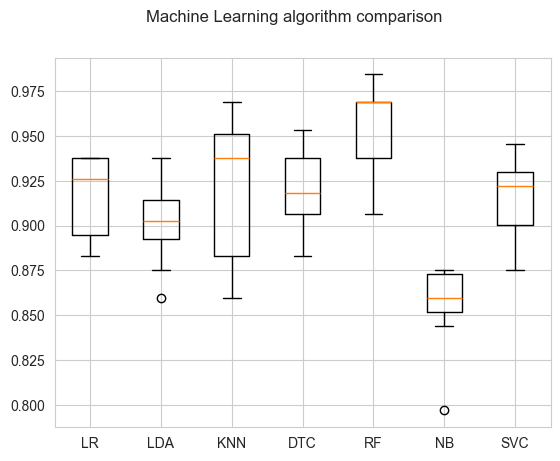

In [98]:
#Model training and evaluation
print("[O_O] training started...")
for name, model in models:
    kfold = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True) 
    #You can switch between stratified K-fold and normal K-fold here
    cross_val_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring) 
    results.append(cross_val_results) #Saving the results for the box plot
    names.append(name)
    
    print("%s: %f (%f)" % (name, cross_val_results.mean(), cross_val_results.std()))

#Boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Results
Random forest classification seems to be the best performer across all the classical ML algorithms that I've tested.
Here is the breakdown of the performance of this model on its own:

In [99]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [100]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

Testing the algorithm

In [101]:
y_predict=clf.predict(testDataGlobal)

In [102]:
y_predict

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

Confusion matrix

In [103]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

<Axes: >

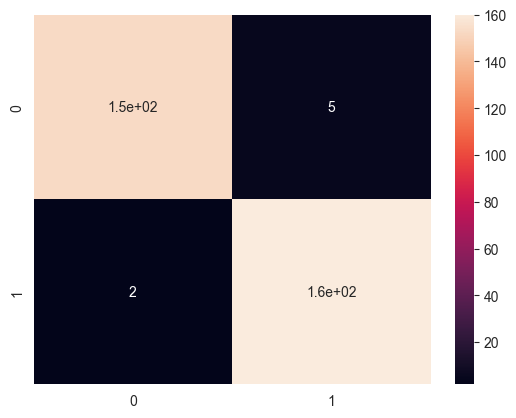

In [104]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [105]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.97      0.99      0.98       162

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320


In [106]:
from sklearn.metrics import accuracy_score

In [107]:
accuracy_score(testLabelsGlobal, y_predict) #Final accuracy score of random forest classification

0.978125